In [1]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.seasonal import seasonal_decompose  

In [2]:



# Função de denoising com wavelet
def wavelet_denoising(signal, wavelet='sym18', level=2):
    coeffs = pywt.wavedec(signal, wavelet, mode='periodization', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='periodization')
    return reconstructed_signal[:len(signal)]

# Função para encontrar a melhor janela de previsão baseada no ACF
def best_prediction_window(signal, max_lag=288):
    max_lag = min(len(signal) - 1, max_lag)
    acf_values = acf(signal, nlags=max_lag, fft=False)
    threshold = 1 / np.e
    diffs = acf_values - threshold
    crossings = np.where((diffs[:-1] > 0) & (diffs[1:] <= 0))[0]
    if len(crossings) > 0:
        best_window = crossings[-1] + 1
    else:
        best_window = max_lag
    return best_window, acf_values

# Função para calcular a Average Mutual Information (AMI)
def calculate_ami(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Função para encontrar todos os mínimos locais na curva de AMI
def find_all_minimums_ami(ami_values):
    minima = []
    for i in range(1, len(ami_values)-1):
        if ami_values[i] < ami_values[i-1] and ami_values[i] < ami_values[i+1]:
            minima.append(i+1)  # +1 para ajustar o índice devido ao lag iniciar em 1
    return minima

# Função para determinar os lags usando AMI
def select_lags_ami(signal, max_lag=288, bins=20):
    ami_values = [calculate_ami(signal[:-lag], signal[lag:]) for lag in range(1, max_lag+1)]
    minima = find_all_minimums_ami(ami_values)
    maxima = []  # Inicialização para evitar erro, caso seja necessária
    return minima, maxima, ami_values

# Função para criar features de rolling
def create_rolling_features(df, windows):
    df_rolled = pd.DataFrame(index=df.index)
    for window_name, window_size in windows.items():
        for col in df.columns:
            df_rolled[f'{col}_rolling_mean_{window_name}'] = df[col].rolling(window=window_size, min_periods=1).mean()
    return df_rolled


In [3]:

# Leitura dos dados
data = pd.read_csv("dataset.csv")

# Processamento inicial dos dados
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0])
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce')
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str'], inplace=True)
variables = pd.DataFrame(index=data.index)

# Lista de colunas a serem denoizadas
columns_to_denoise = ['ws100', 'humid', 'wdisp100', 'vertdisp100', 'wdir100', 'temp', 'press']


In [4]:

# 1. Extração de features de tendência, resíduo e sazonalidade usando statsmodels
# Definindo um DataFrame para armazenar as novas features
decomposed_features = pd.DataFrame(index=data.index)

for col in columns_to_denoise:
    # Decomposição da série temporal
    decomposition = seasonal_decompose(
        data[col], 
        model='additive', 
        period=72,  # Exemplo de período (ajuste conforme necessário)
        extrapolate_trend='freq'  # Adiciona extrapolação para preencher NaNs
    )
    # Preenchendo os NaNs nas componentes de trend e resid
    trend_filled = decomposition.trend.fillna(method='bfill').fillna(method='ffill')
    resid_filled = decomposition.resid.fillna(method='bfill').fillna(method='ffill')
    
    decomposed_features[f'{col}_trend'] = trend_filled
    decomposed_features[f'{col}_seasonal'] = decomposition.seasonal  # Geralmente não possui NaNs
    decomposed_features[f'{col}_resid'] = resid_filled

    # Plotando as componentes
    # fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    # axes[0].plot(data.index, data[col], label='Original', alpha=0.5)
    # axes[0].set_title(f'Original vs Wavelet Denoised para {col}')
    # axes[0].legend()

    # axes[1].plot(decomposed_features.index, decomposed_features[f'{col}_trend'], label='Trend', color='green')
    # axes[1].set_title(f'Trend para {col}')
    # axes[1].legend()

    # axes[2].plot(decomposed_features.index, decomposed_features[f'{col}_seasonal'], label='Seasonal', color='red')
    # axes[2].set_title(f'Seasonal para {col}')
    # axes[2].legend()
    
    # axes[3].plot(decomposed_features.index, decomposed_features[f'{col}_resid'], label='Resid', color='blue')
    # axes[3].set_title(f'Resid para {col}')
    # axes[3].legend()

    # plt.tight_layout()
    # plt.show()


/tmp/ipykernel_1872/3559675786.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_filled = decomposition.trend.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1872/3559675786.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resid_filled = decomposition.resid.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1872/3559675786.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_filled = decomposition.trend.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1872/3559675786.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resid_filled = decomposition.resid.fillna(method='bfill').fillna(

In [5]:

# Denoising e armazenamento das variáveis
for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal
    else:
        raise ValueError(f"A coluna '{col}' não existe no conjunto de dados.")


Mínima: Lag selecionado usando AMI para ws100_wavelet: [33, 39, 46, 49, 57, 90, 102, 105, 108, 112, 119, 176, 186, 188, 192, 198, 200, 202, 208, 214, 226, 231, 234, 238, 242, 249, 255, 258, 262, 270, 281, 285, 287]
Mínima: Lag selecionado usando AMI para humid_wavelet: [37, 70, 77, 108, 176, 209, 211, 214, 217, 253]
Mínima: Lag selecionado usando AMI para wdisp100_wavelet: [36, 39, 41, 49, 54, 58, 63, 70, 78, 81, 92, 95, 98, 102, 107, 109, 144, 179, 182, 185, 188, 193, 197, 199, 202, 207, 216, 218, 222, 226, 230, 233, 235, 246, 249, 251, 253, 259, 265]
Mínima: Lag selecionado usando AMI para vertdisp100_wavelet: [35, 71, 112, 173, 203, 214, 252, 257]
Mínima: Lag selecionado usando AMI para wdir100_wavelet: [36, 39, 43, 60, 69, 73, 78, 105, 112, 175, 196, 199, 207, 212, 214, 223, 258, 260]
Mínima: Lag selecionado usando AMI para temp_wavelet: [31, 72, 110, 176, 214, 253]
Mínima: Lag selecionado usando AMI para press_wavelet: [29, 44, 46, 72, 95, 97, 116, 169, 193, 236, 263]
A melhor jan

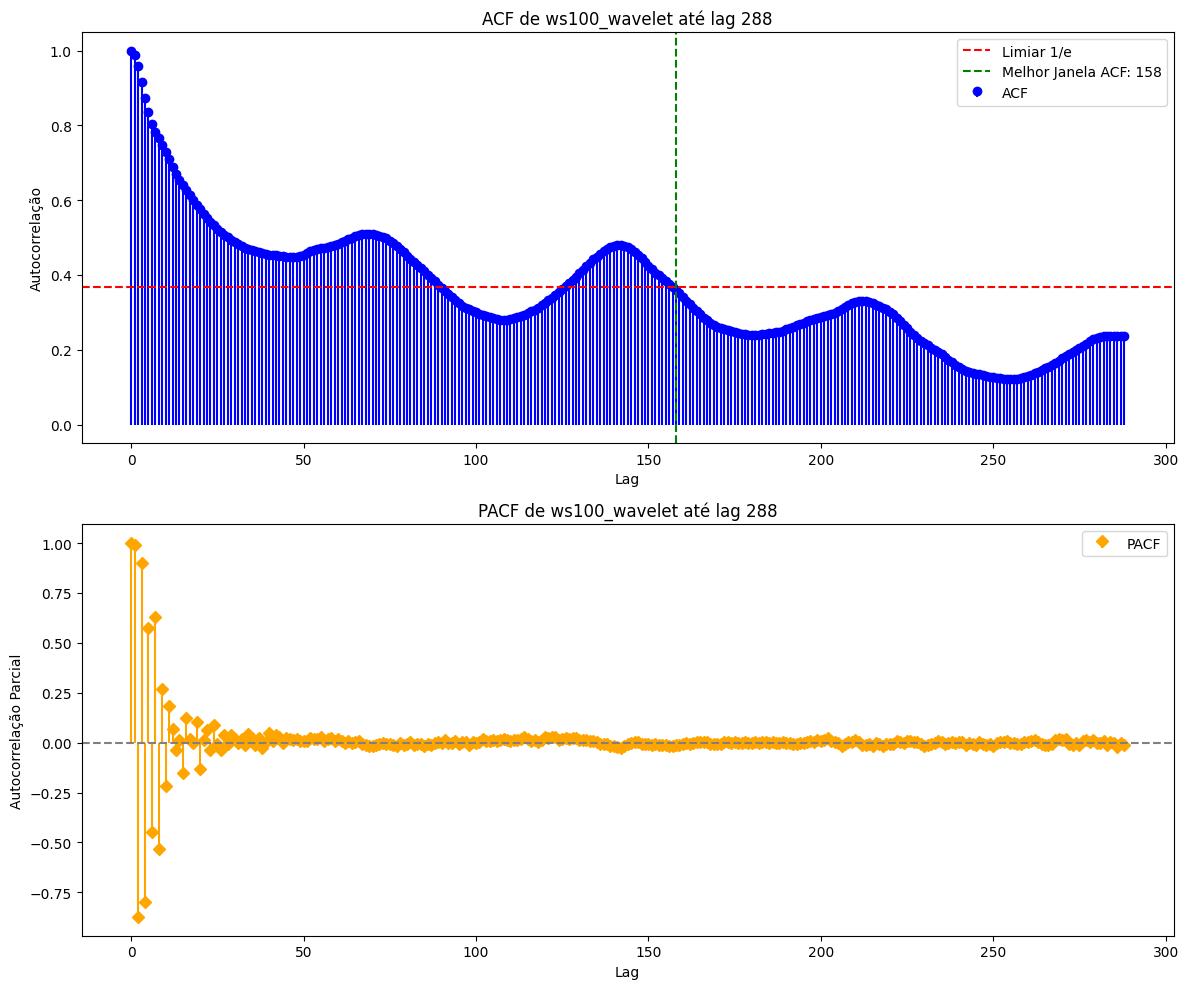

A melhor janela de previsão para humid_wavelet com ACF é 165.


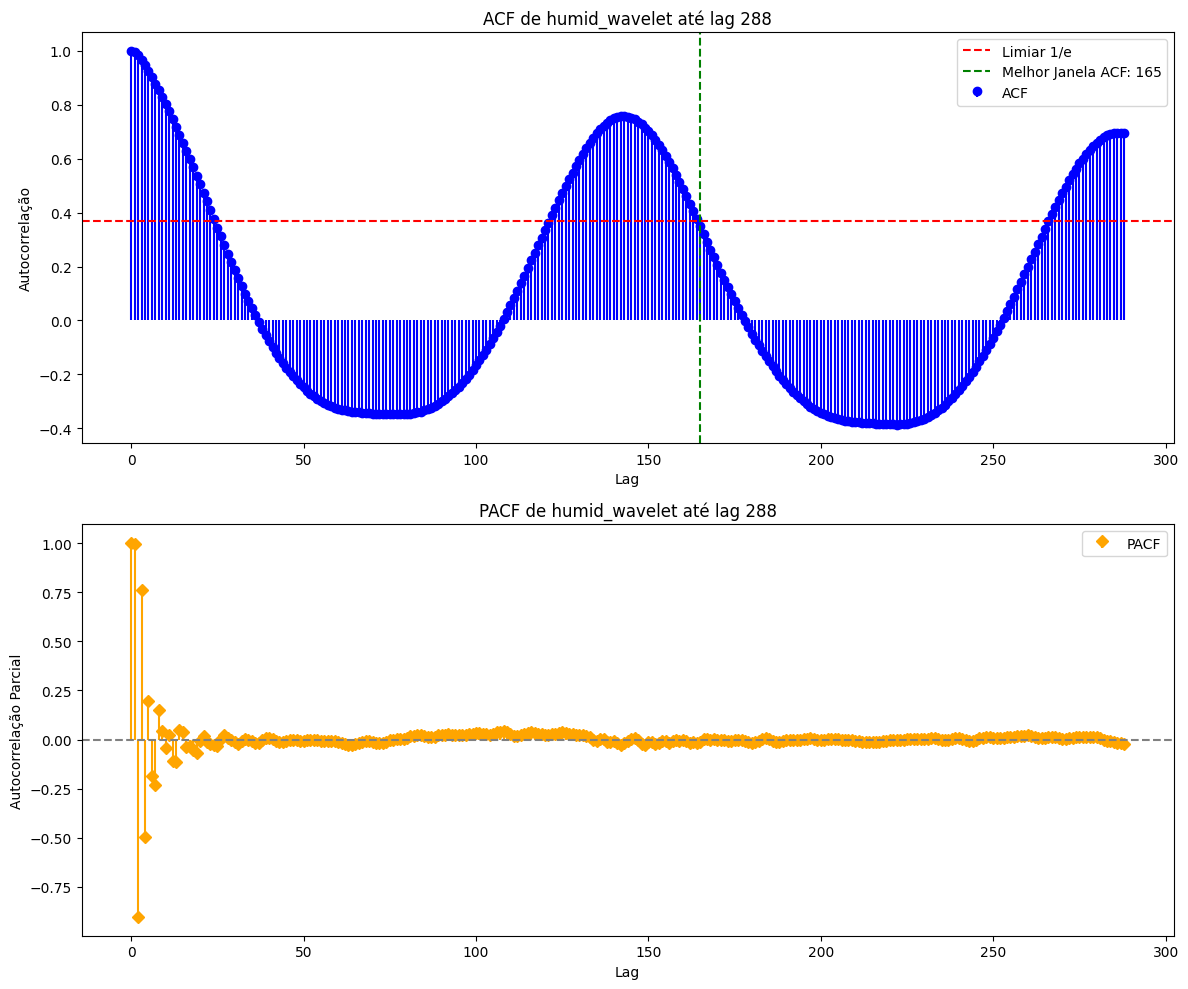

A melhor janela de previsão para wdisp100_wavelet com ACF é 166.


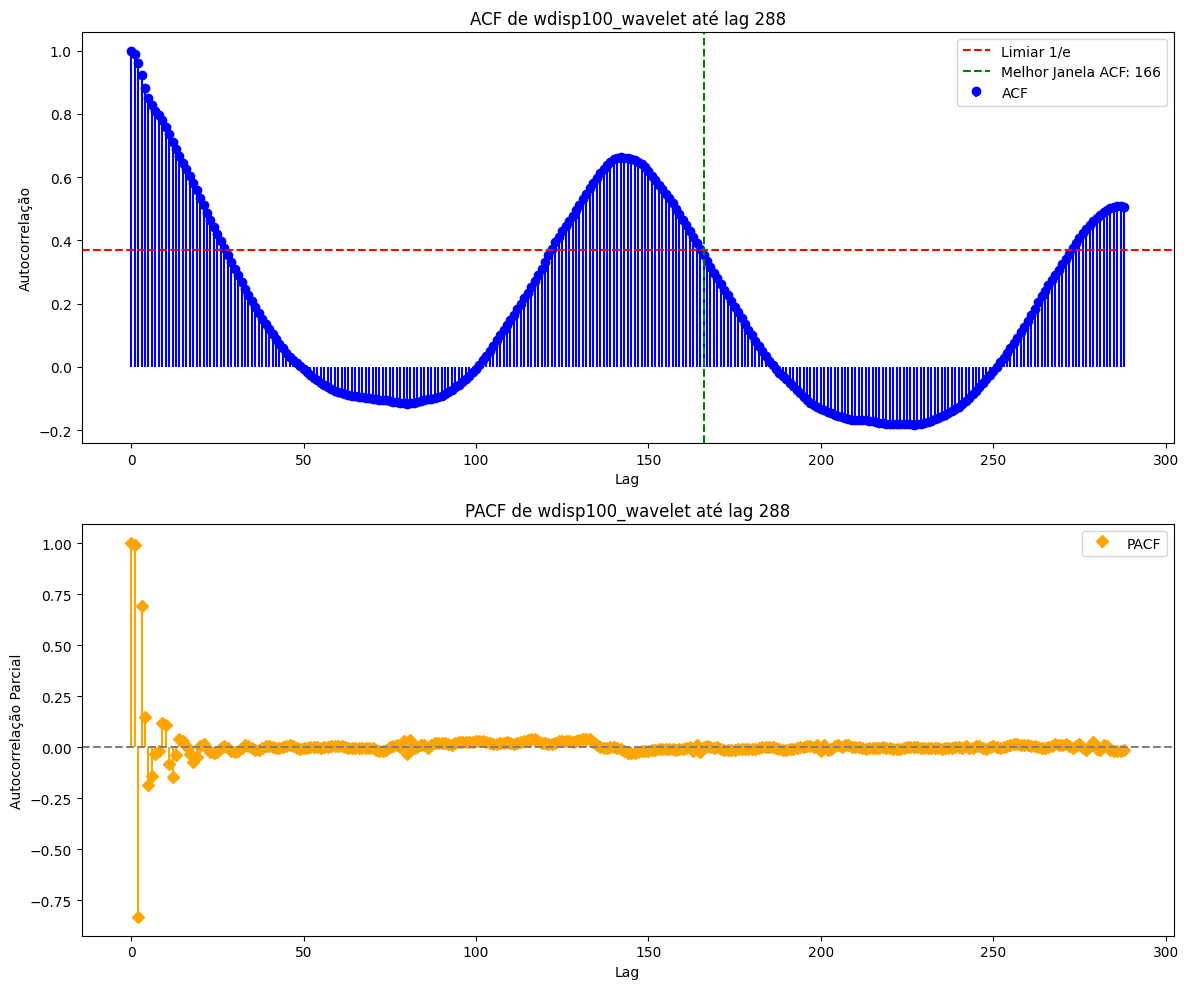

A melhor janela de previsão para vertdisp100_wavelet com ACF é 166.


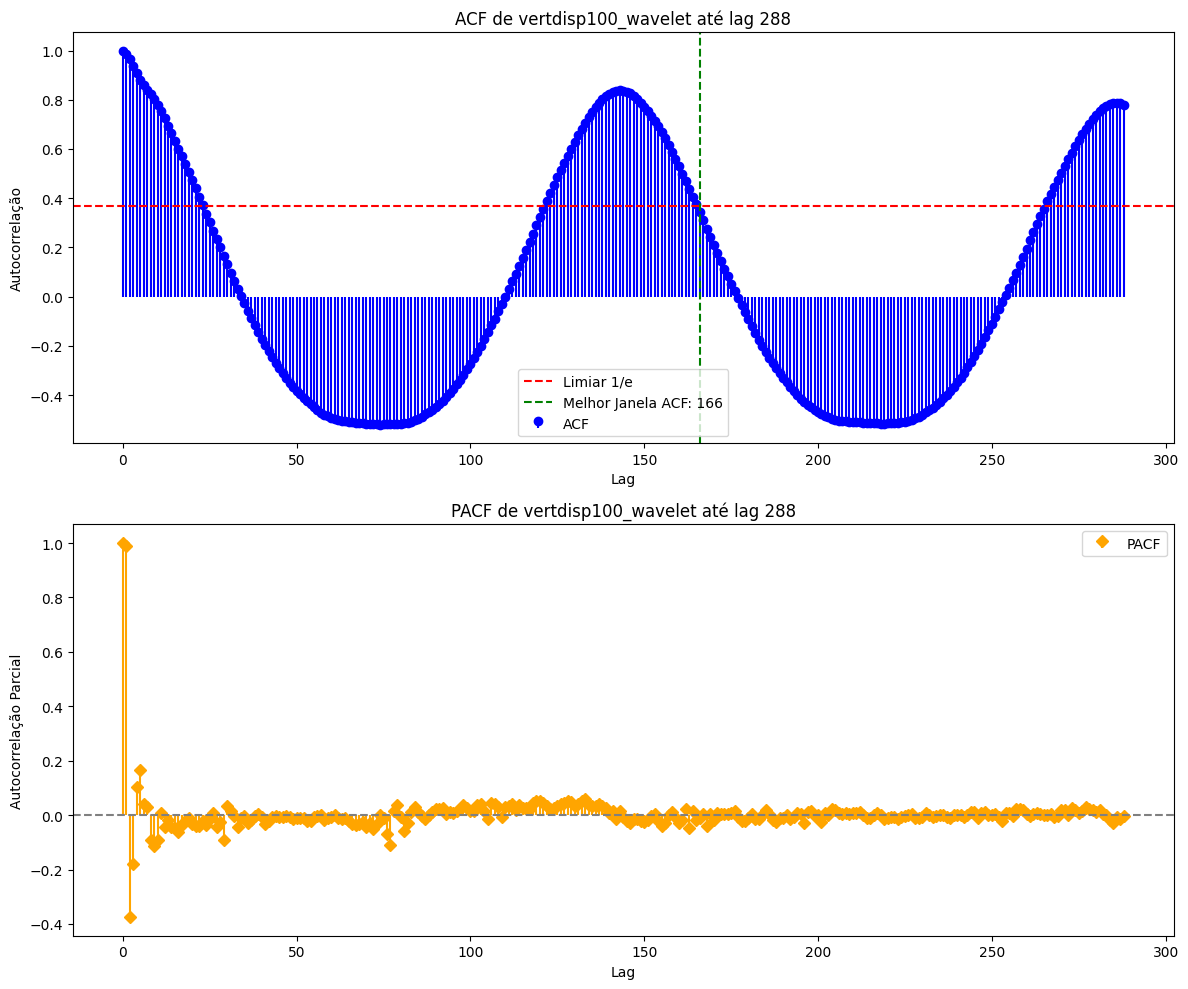

A melhor janela de previsão para wdir100_wavelet com ACF é 159.


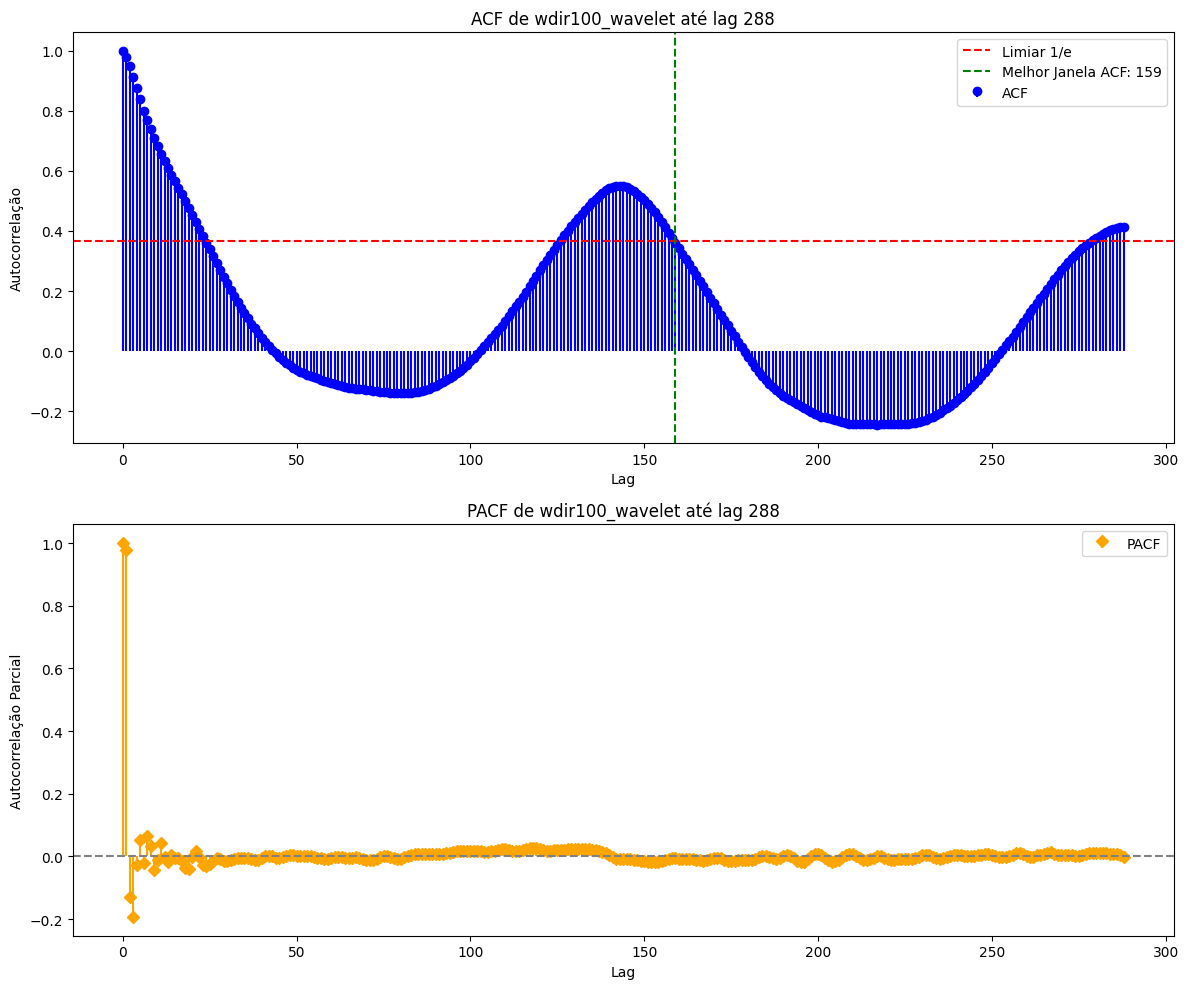

A melhor janela de previsão para temp_wavelet com ACF é 165.


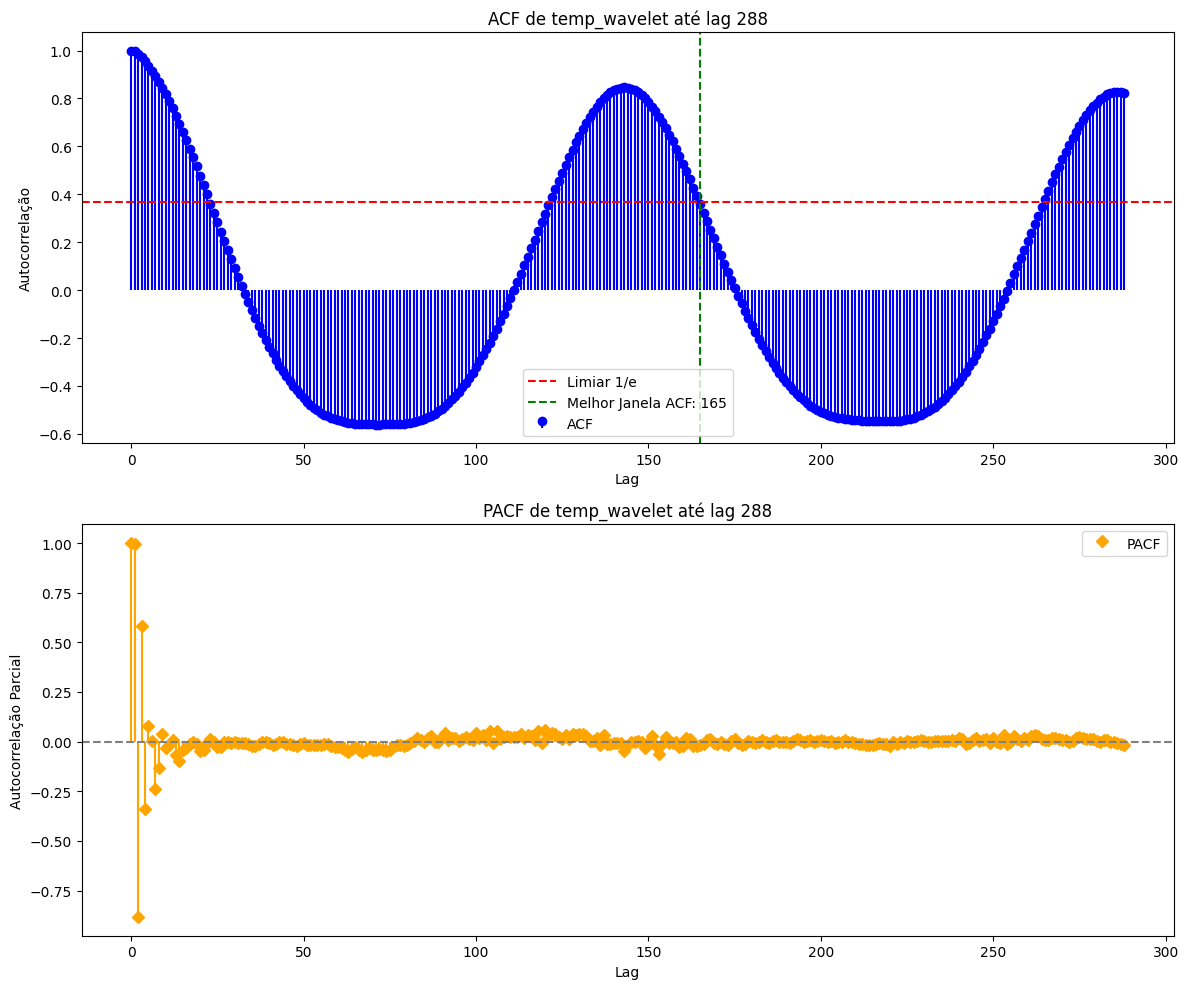

A melhor janela de previsão para press_wavelet com ACF é 225.


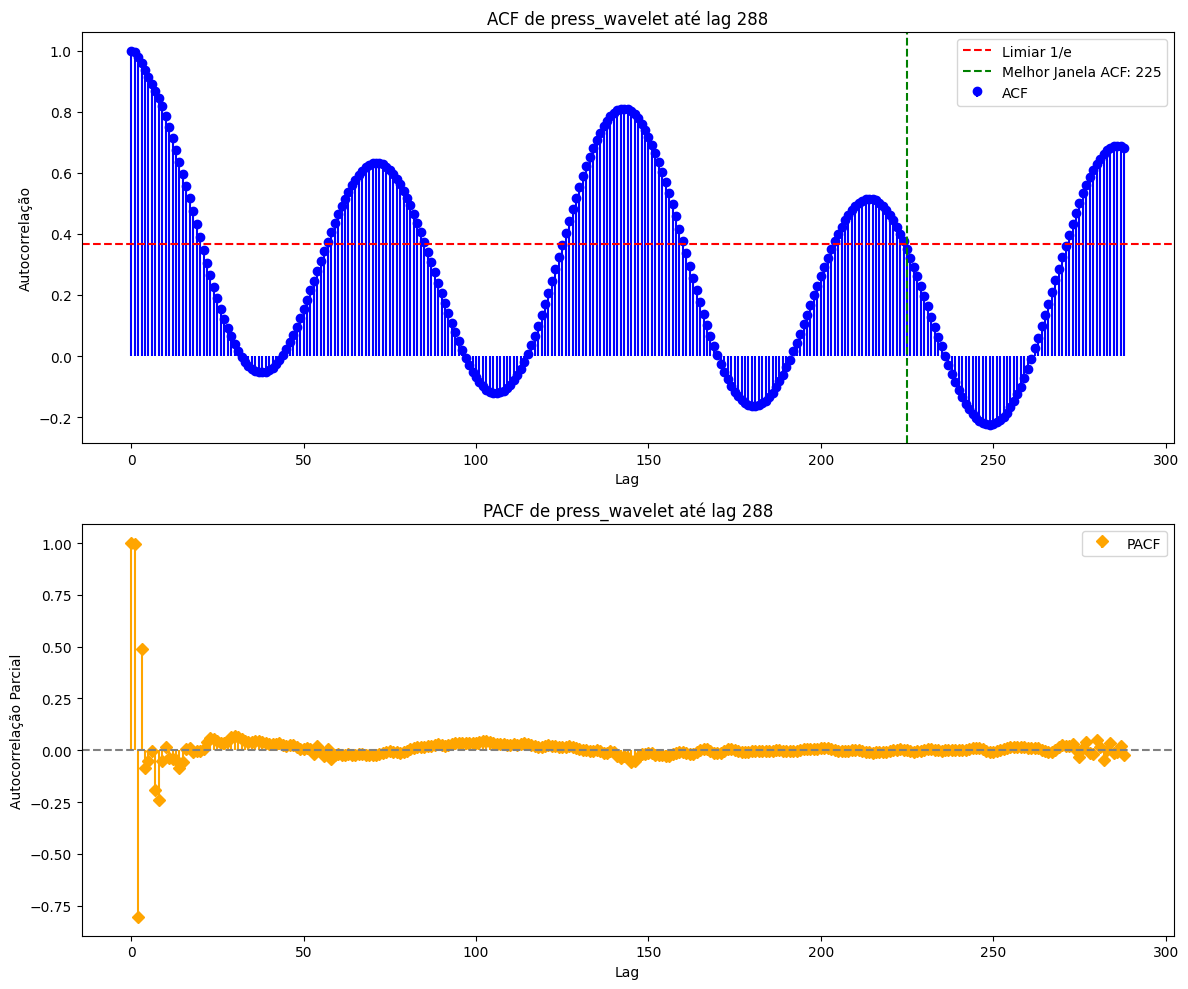

In [6]:

# Seleção de lags para cada variável usando AMI
lags_selected = {}
for col in variables.columns:
    signal = variables[col].dropna()
    minima, maxima, ami_values = select_lags_ami(signal, max_lag=288, bins=20)
    if len(minima) == 0:
        selected_lag = 1  # Padrão, caso nenhum mínimo seja encontrado
    elif len(minima) == 1:
        selected_lag = minima[0]
    else:
        selected_lag = minima[1]  # Seleciona o segundo mínimo
    lags_selected[col] = selected_lag
    print(f"Mínima: Lag selecionado usando AMI para {col}: {minima}")

# Cálculo de ACF e PACF e plotagem
for col in variables.columns:
    signal = variables[col].dropna()
    best_window, acf_values = best_prediction_window(signal, max_lag=288)
    pacf_values = pacf(signal, nlags=288, method='ols')  # Calculando PACF

    print(f"A melhor janela de previsão para {col} com ACF é {best_window}.")

    # Configurando os subplots para ACF e PACF
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot do ACF
    axes[0].stem(range(len(acf_values)), acf_values, linefmt='b-', markerfmt='bo', basefmt=" ", label='ACF')
    axes[0].axhline(y=1 / np.e, color='red', linestyle='--', label='Limiar 1/e')
    axes[0].axvline(x=best_window, color='green', linestyle='--', label=f'Melhor Janela ACF: {best_window}')
    axes[0].set_title(f'ACF de {col} até lag {288}')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelação')
    axes[0].legend()

    # Plot da PACF
    axes[1].stem(range(len(pacf_values)), pacf_values, linefmt='orange', markerfmt='D', basefmt=" ", label='PACF')
    axes[1].axhline(y=0, color='gray', linestyle='--')
    axes[1].set_title(f'PACF de {col} até lag {288}')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Autocorrelação Parcial')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Features de rolling criadas.


/tmp/ipykernel_1872/1096853054.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  variables_engineered.fillna(method='bfill', inplace=True)
/tmp/ipykernel_1872/1096853054.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  variables_engineered.fillna(method='ffill', inplace=True)


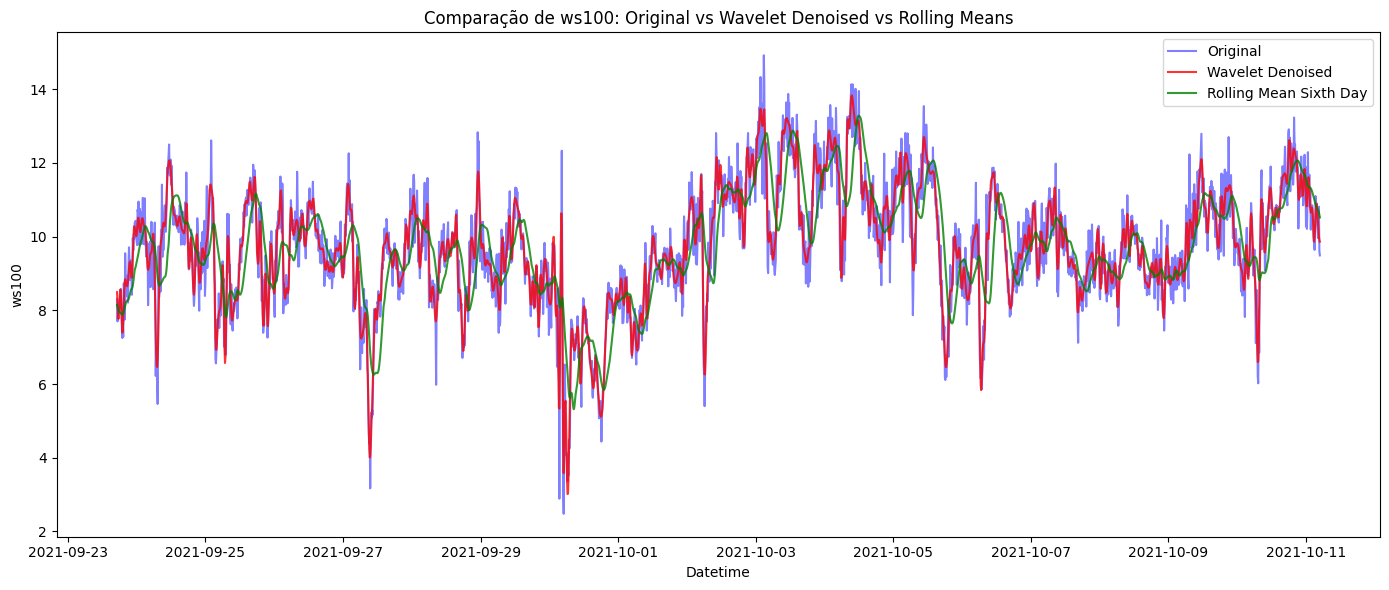

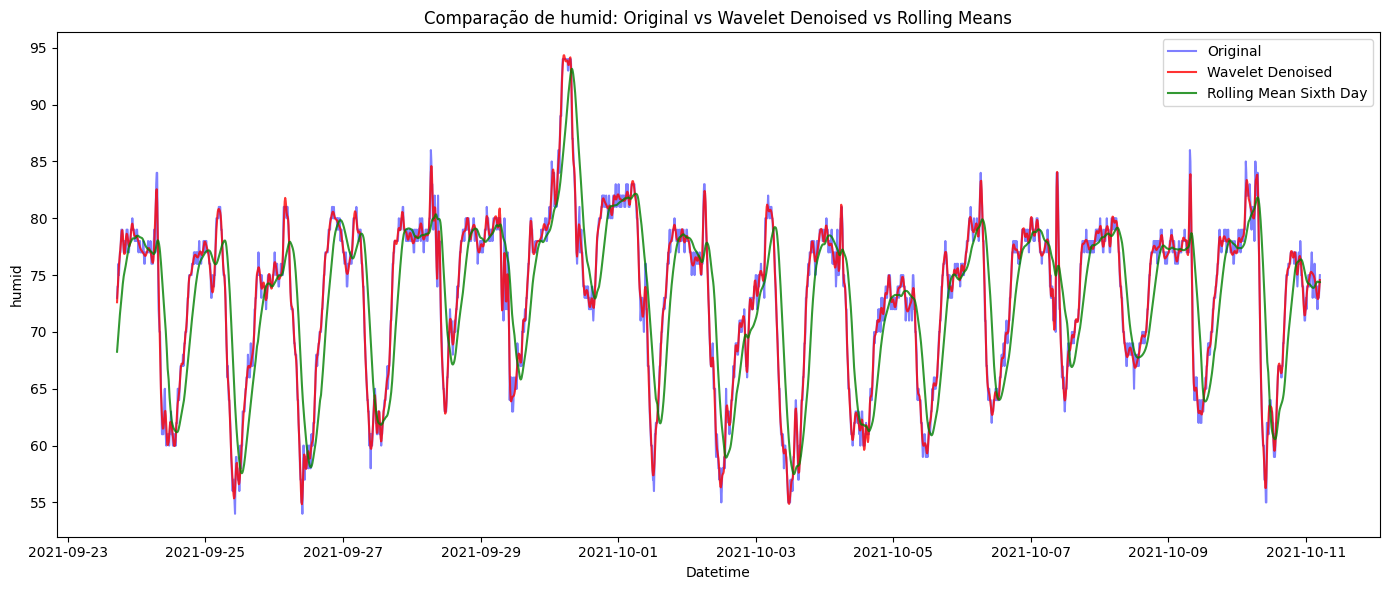

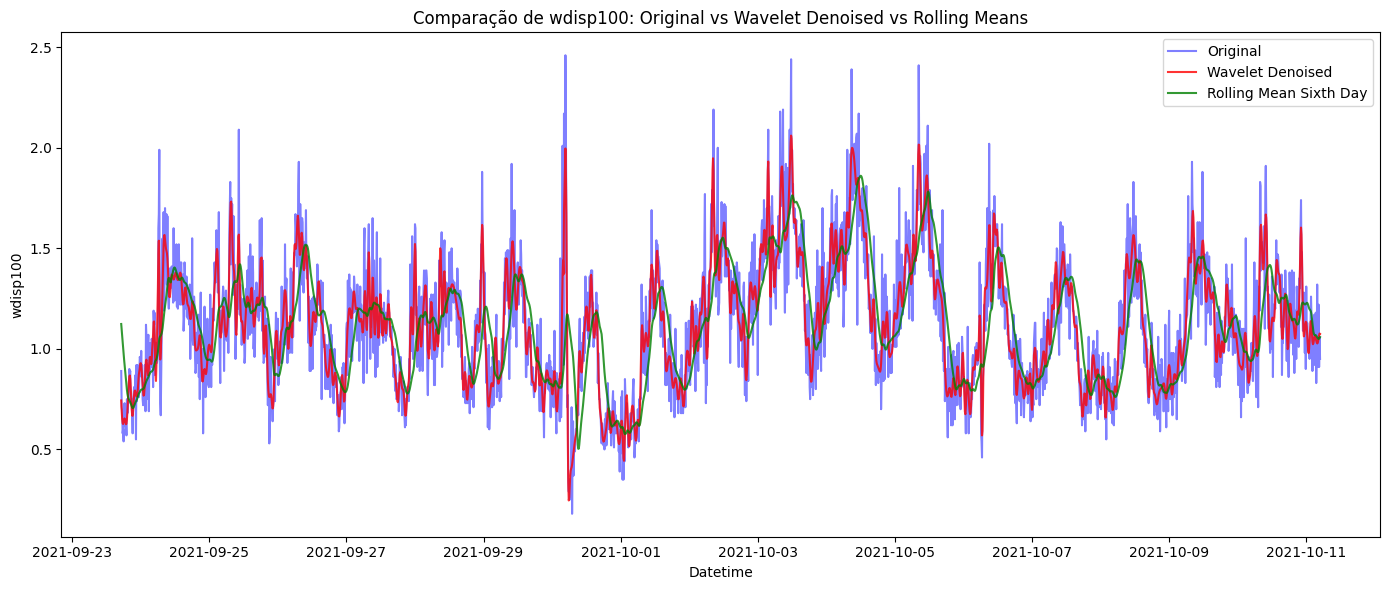

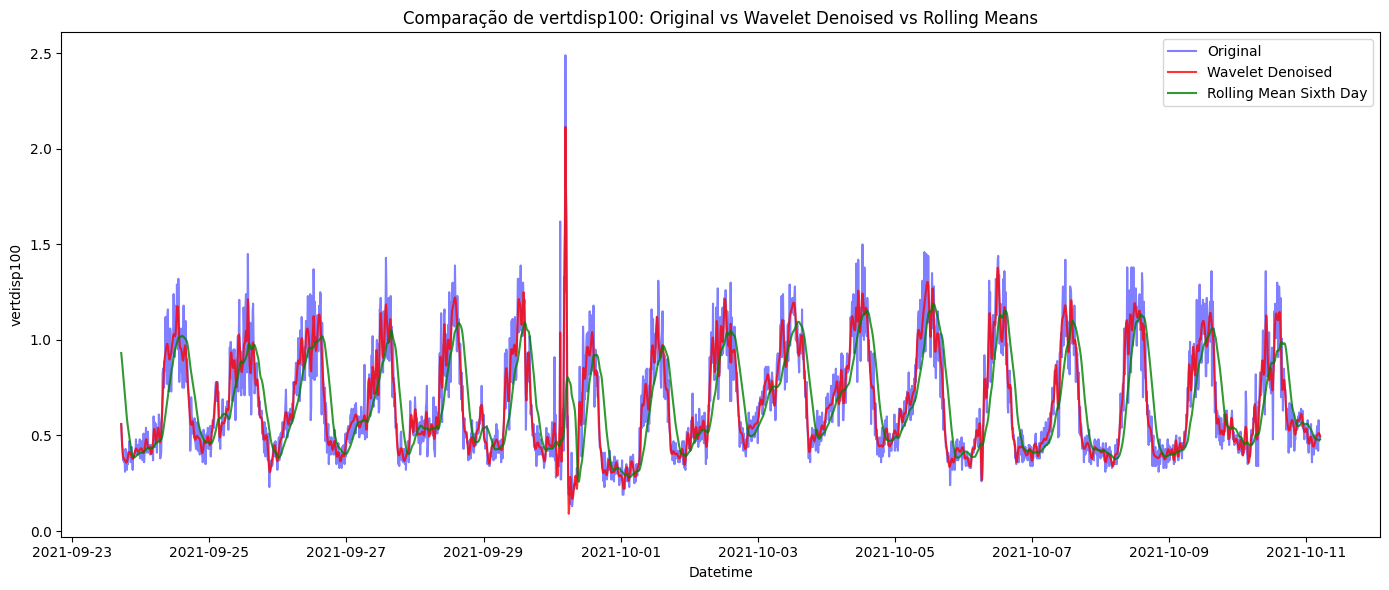

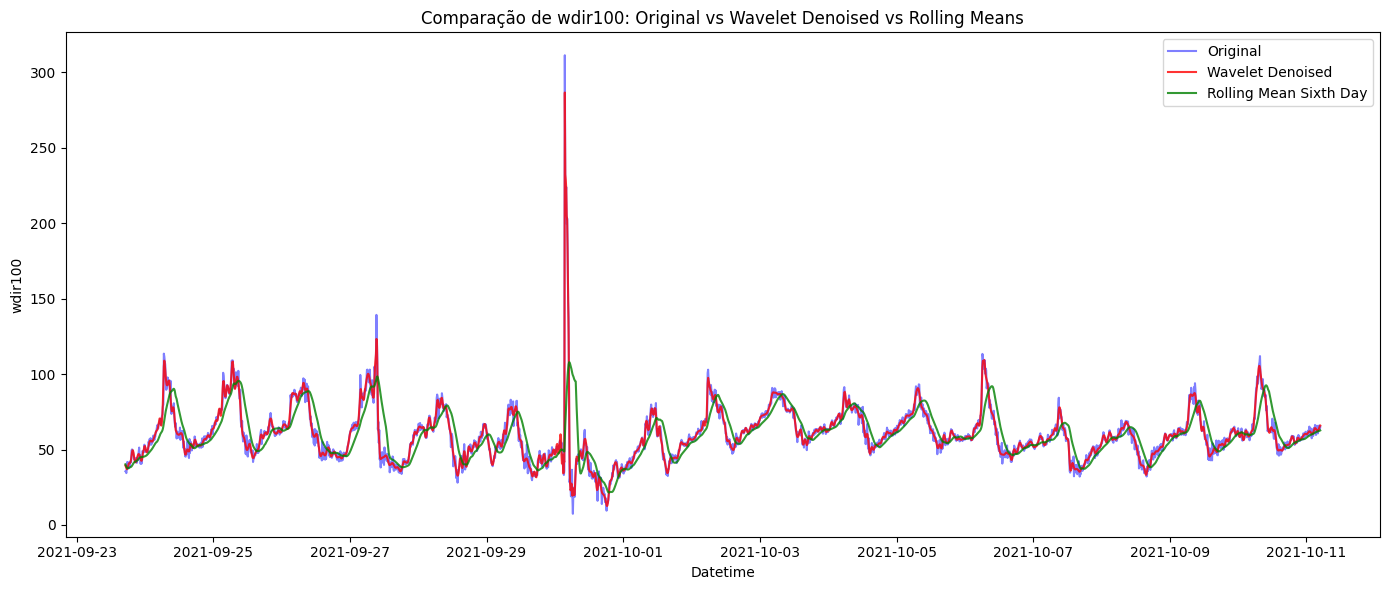

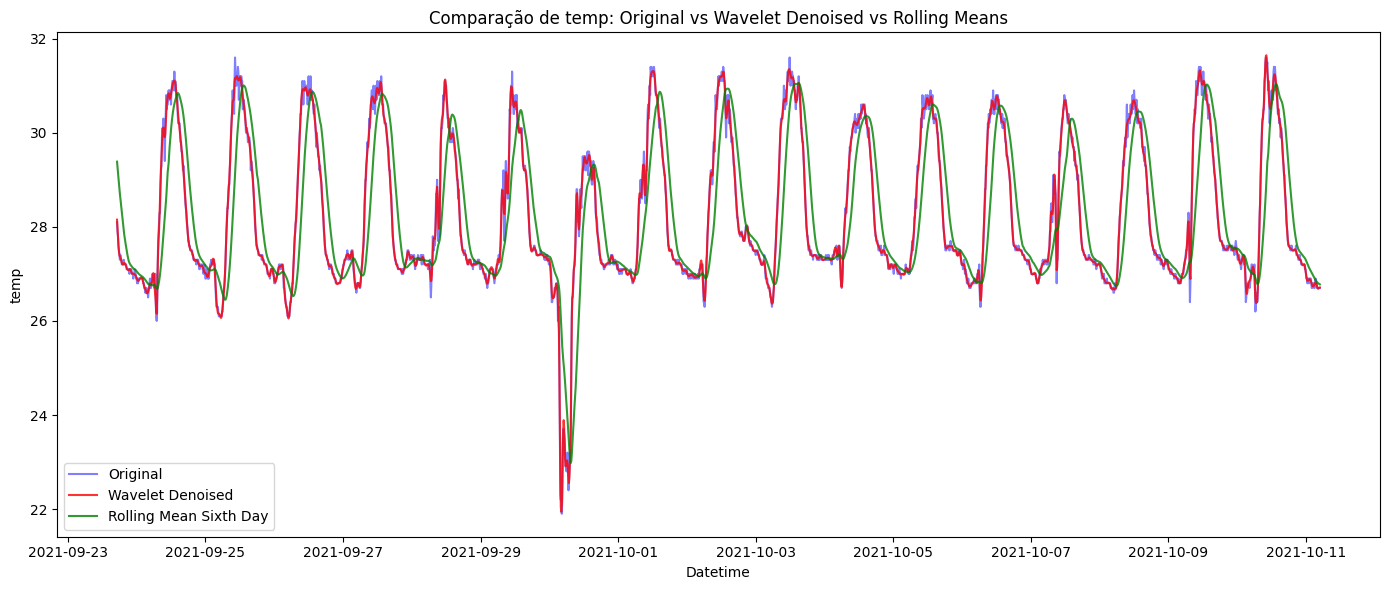

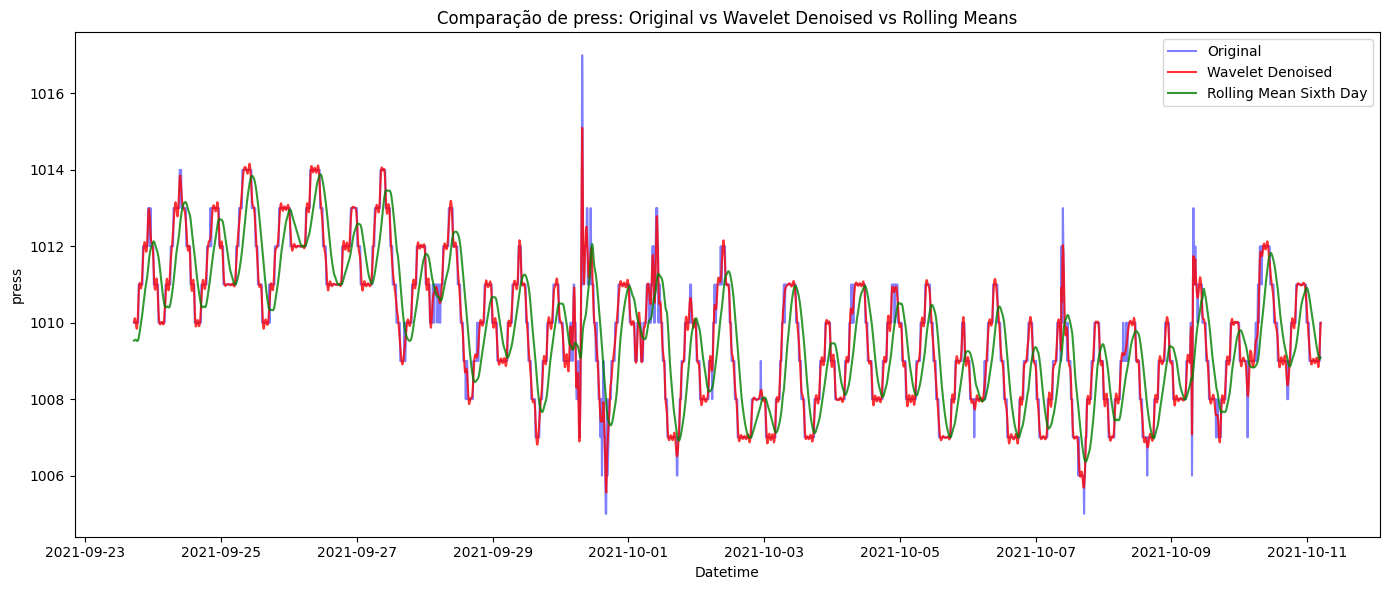

In [7]:

# Seleção de variáveis com variância não nula
selector = VarianceThreshold(threshold=0.0)
selector.fit(variables)
features_selected = variables.columns[selector.get_support()]
variables = variables[features_selected]

### Engenharia de Features ###

# Definição das janelas de rolling
rolling_windows = {
    'sixth_day': 24  # 4 horas
}

# Criando features de rolling
rolling_features = create_rolling_features(variables, rolling_windows)
print("Features de rolling criadas.")

# Combinar as features originais com as novas features
variables_engineered = pd.concat([variables, rolling_features], axis=1)

# Preenchendo valores ausentes resultantes de rolling e lags
variables_engineered.fillna(method='bfill', inplace=True)
variables_engineered.fillna(method='ffill', inplace=True)

### Fim da Engenharia de Features ###

# ----- Adições Iniciam Aqui -----

# 1. Gráfico comparativo da curva original, denoised e rolling means
for col in columns_to_denoise:
    if f'{col}_wavelet' in variables_engineered.columns:
        plt.figure(figsize=(14, 6))
        plt.plot(data.index[1000:3500], data[col][1000:3500], label='Original', alpha=0.5, color= 'blue')
        plt.plot(variables_engineered.index[1000:3500], variables_engineered[f'{col}_wavelet'][1000:3500], label='Wavelet Denoised', alpha=0.8, color = 'red')
        # Adicionando médias móveis
        # rolling_mean_half_day = variables_engineered[f'{col}_wavelet_rolling_mean_half_day']
        rolling_mean_quarter_day = variables_engineered[f'{col}_wavelet_rolling_mean_sixth_day']
        # plt.plot(variables_engineered.index[1000:3500], rolling_mean_half_day[1000:3500], label='Rolling Mean Half Day', color='red')
        plt.plot(variables_engineered.index[1000:3500], rolling_mean_quarter_day[1000:3500], label='Rolling Mean Sixth Day', alpha = 0.8, color='green')
        plt.title(f'Comparação de {col}: Original vs Wavelet Denoised vs Rolling Means')
        plt.xlabel('Datetime')
        plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
        plt.show()


# Adicionando as features de tendência, sazonalidade e resíduo ao DataFrame engineered
variables_engineered = pd.concat([variables_engineered], axis=1)

# 3. Opcional: Atualizar seleção de variáveis com as novas features se necessário
# (Depende da sua estratégia de feature selection)

# ----- Adições Terminam Aqui -----



Features com correlação >= 1/e (em valor absoluto) com 'ws100_wavelet':

humid_wavelet                             -0.444100
wdisp100_wavelet                           0.635847
vertdisp100_wavelet                        0.409078
ws100_wavelet_rolling_mean_sixth_day       0.815323
wdisp100_wavelet_rolling_mean_sixth_day    0.580942
Name: ws100_wavelet, dtype: float64


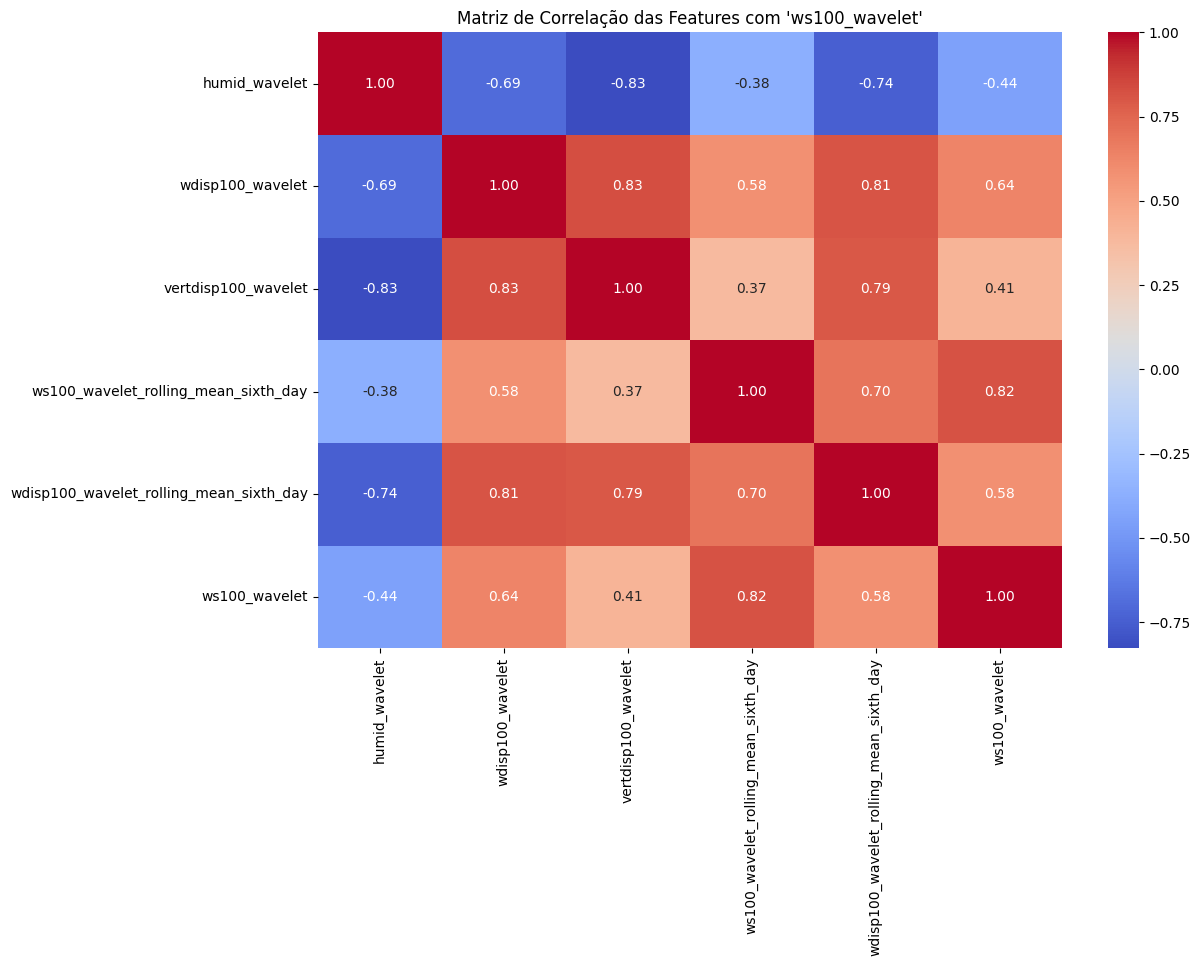

Dados processados com engenharia de features salvos em 'processed_variables_engineered.csv'.


In [8]:

# %%
# Cálculo da matriz de correlação
corr_matrix = variables_engineered.corr()

if 'ws100_wavelet' in corr_matrix.columns:
    ws100_corr = corr_matrix['ws100_wavelet']
    high_corr_features = ws100_corr[corr_matrix['ws100_wavelet'].abs() >= 1/np.e].drop('ws100_wavelet', errors='ignore')
else:
    raise ValueError("A coluna 'ws100_wavelet' não existe na matriz de correlação.")

print("\nFeatures com correlação >= 1/e (em valor absoluto) com 'ws100_wavelet':\n")
print(high_corr_features)

# Matriz de correlação das features selecionadas
high_corr_df = variables_engineered[high_corr_features.index.tolist() + ['ws100_wavelet']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(high_corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Features com 'ws100_wavelet'")
plt.show()

variables_engineered = variables_engineered[high_corr_features.index.tolist() + ['ws100_wavelet']].copy()

# Salvando as variáveis processadas com as novas features
variables_engineered.to_csv('processed_variables_engineered.csv', index=True)
print("Dados processados com engenharia de features salvos em 'processed_variables_engineered.csv'.")


